In [1]:
from pathlib import Path

INPUT_PATH = Path('../inputs/mnist/cnn')
OUTPUT_PATH = Path('../outputs/mnist/cnn')

INPUT_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from collections import OrderedDict
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(999)

class Net(nn.Module):
    def __init__(self, in_dim, in_channel, out_size):
        super(Net, self).__init__()
        layer1 = self.get_conv_relu_maxpool(in_channel, 20, 3, 2)
        layer1_out = layer1(torch.rand((1, 1, 28, 28)))
        
        layer2 = nn.Linear(layer1_out.flatten(1).size(-1), out_size)
        self.layers = nn.ModuleList([layer1, layer2])
        self.forward_vals = []
        
    def forward(self, x):
        self.forward_vals.clear()
        for layer in self.layers:
            if isinstance(layer, nn.Linear) and len(x.size()) > 2:
                x = x.flatten(1)
            x = layer(x)
            self.forward_vals.append(x)
        return x
    
    def get_conv_relu_maxpool(self, in_channel, num_filters, kernel_size, pool_size):
        return nn.Sequential(nn.Conv2d(in_channel, num_filters, kernel_size),
                             nn.ReLU(),
                             nn.MaxPool2d(pool_size))
    
    def get_linear_with_relu(self, inp, out):
        return nn.Sequential(nn.Linear(inp, out), nn.ReLU())
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
train_kwargs = {'batch_size': batch_size,
               'shuffle': True}
test_kwargs = {'batch_size': batch_size,
              'shuffle': True}

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

dataset1 = datasets.MNIST(INPUT_PATH/'mnist', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST(INPUT_PATH/'mnist', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = Net(28, 1, 10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model

Net(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Linear(in_features=3380, out_features=10, bias=True)
  )
)

In [3]:
len(train_loader)*batch_size

60032

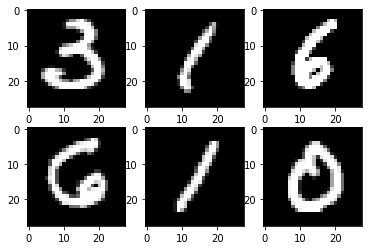

In [4]:
from matplotlib import pyplot as plt

examples = iter(test_loader)
example_data, example_targets = examples.next()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

### Target Model Training

If you have not already trained a model, uncomment the below cell and run it

In [5]:
# import copy
# import warnings
# warnings.filterwarnings("ignore") 

# def train(model, device, train_loader, optimizer, epoch):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         # print(data.size(), data.view(data.size(0), -1).size())
#         optimizer.zero_grad()
#         output = model(data)
#         loss = F.cross_entropy(output, target)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % 100 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
            

# def test():
#     with torch.no_grad():
#         n_correct = 0
#         n_samples = 0
#         for images, labels in test_loader:
#             images = images.to(device)
#             labels = labels.to(device)
#             outputs = model(images)
#             # max returns (value ,index)
#             _, predicted = torch.max(outputs.data, 1)
#             n_samples += labels.size(0)
#             n_correct += (predicted == labels).sum().item()

#     acc = 100.0 * n_correct / n_samples
#     print(f'Accuracy of the network on the 10000 test images: {acc} %')
#     return acc


# best_acc = -1
# best_model = None
# for epoch in range(1, 10):
#     train(model, device, train_loader, optimizer, epoch)
#     acc = test()
#     if acc > best_acc:
#         best_acc = acc
#         best_model = copy.deepcopy(model)
#         print(f'new best acc={best_acc}')
#     else:
#         print(f'current acc={acc}, prev_best_acc={best_acc}')

# state = {
#     'model_state': best_model.state_dict(),
#     'test_acc': best_acc
# }
# torch.save(state, OUTPUT_PATH/'state_small_nn.pt')
# print('best model saved')

### Reverse Model Training

In [3]:
state = torch.load(OUTPUT_PATH/'state_small_nn.pt')
state.keys()

dict_keys(['model_state', 'test_acc'])

In [4]:
model.load_state_dict(state['model_state'])
model.to(device)

for param in model.parameters():
    param.requires_grad = False
                                 
model

Net(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Linear(in_features=3380, out_features=10, bias=True)
  )
)

In [5]:
config_dict = {
    'epochs': 1000000,
    'alpha': 1,
    'lr': 1e-3,
    'lr_sched': 'none',
    'gamma': 0.99,
    'loss': 'abs',
    'min_lr': 1e-5
}

In [6]:
class InvNet(nn.Module):
    def __init__(self, input_size, out_dim, out_channel):
        super(InvNet, self).__init__()
        layer1 = self.get_linear_with_relu(input_size, 3380)
        layer2 = self.get_conv_relu_maxpool(20, 1, 2, 3, 1, 5, 1)  # 20, 1, 2, 3, 1, 5, 1
        self.layers = nn.ModuleList([layer1, layer2])
        self.forward_vals = []
        
    def forward(self, x):
        self.forward_vals.clear()
        for layer in self.layers:
            if isinstance(layer[0], nn.ConvTranspose2d) and len(x.size()) <= 2:
                x = x.view(x.size(0), 20, 13, 13)  # out dims of conv2d of target model
            x = layer(x)
            self.forward_vals.append(x)
        return x
    
    def get_conv_relu_maxpool(self, in_channel, num_filters, kernel_size, stride, pool_size, padding, dilation):
        return nn.Sequential(nn.ConvTranspose2d(in_channel, num_filters, kernel_size, 
                                                stride=stride, padding=padding, dilation=dilation,
                                                bias=True),
                             # nn.ReLU(),
                             # nn.MaxPool2d(pool_size)
                            )
    
    def get_linear_with_relu(self, inp, out):
        return nn.Sequential(nn.Linear(inp, out), nn.LeakyReLU())

    
inv_model = InvNet(10, 28, 1)
inv_model.to(device)
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

test_kwargs = {'batch_size': batch_size,
              'shuffle': True}
train_qmnist = datasets.QMNIST(INPUT_PATH/'qmnist', train = True, download= True,
                             transform=transform) 
test_qmnist = datasets.QMNIST(INPUT_PATH/'qmnist', train = False, download= True,
                             transform=transform)

print(f'size of inv data={train_qmnist}')
inv_data_loader = torch.utils.data.DataLoader(train_qmnist, **test_kwargs)

if config_dict['loss'] == 'abs':
    loss_fn = nn.L1Loss()
else:
    loss_fn = nn.MSELoss()

optimizer = optim.Adam(inv_model.parameters(), lr=config_dict['lr'])

lr_sched = None
if config_dict['lr_sched'] == 'exp':
    lr_sched = optim.lr_scheduler.ExponentialLR(optimizer, config_dict['gamma'], verbose=False)

inv_model

size of inv data=Dataset QMNIST
    Number of datapoints: 60000
    Root location: ../inputs/mnist/cnn/qmnist
    Split: train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


InvNet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=3380, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): ConvTranspose2d(20, 1, kernel_size=(2, 2), stride=(3, 3), padding=(5, 5))
    )
  )
)

In [7]:
s = []
for batch, tgt in inv_data_loader:
    s.append((batch[0].unsqueeze(0), tgt[0]))
    s.append((batch[1].unsqueeze(0), tgt[1]))
    break
len(inv_data_loader), len(s)# inv_model(torch.rand((1, 10, )).to(device)).size()

(469, 2)

In [8]:
for t in s:
    print(t[0].size())

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])


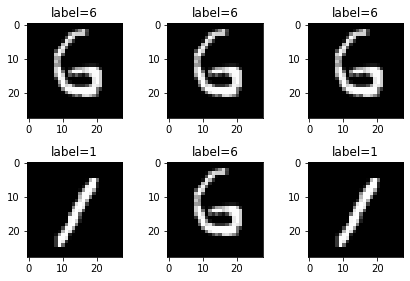

In [9]:
from matplotlib import pyplot as plt
import random

for i in range(6):
    example_data, example_target = s[random.randint(0, 1)]# test_qmnist[random.randint(0, len(test_qmnist))] # TODO for test only change dataloader !!!!!
    ax = plt.subplot(2,3,i+1)
    ax.set_title(f'label={example_target}')
    plt.imshow(example_data.squeeze(), cmap='gray')
plt.tight_layout()
plt.show()

In [12]:
import copy

tgt_to_inv_layer_map = {0: 1, 1: 0}

def train_inv(model, inv_model, device, data_loader, optimizer, epoch, alpha, layer_wise_only=False, layer_num=-1):
    model.train()
    
    total_loss = 0
    total_loss_layer = 0
    total_loss_img = 0
    total_loss_cyc = 0
    
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)  # torch.Size([128, 784]) torch.Size([128])
        optimizer.zero_grad()
    
        out = model(data)  
        inv_out = inv_model(out)
        
        # step 1- layer wise load
        loss_layer = layer_wise_loss(model, inv_model, data)
        
        if not layer_wise_only:
            # step 2- upto layer-k loss
            loss_img = k_layer_loss(model, inv_model, data)

            # step 3- full network output loss
            loss_cyc = cycle_consistency_inversion_loss(model, data, inv_out)
        else:
            loss_img = torch.tensor(0)
            loss_cyc = torch.tensor(0)
        
        loss = loss_layer + loss_img + (alpha*loss_cyc)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_loss_layer += loss_layer.item()
        total_loss_img += loss_img.item()
        total_loss_cyc += loss_cyc.item()
        
    return total_loss / (batch_idx+1), total_loss_layer / (batch_idx+1), \
            total_loss_img / (batch_idx+1), total_loss_cyc / (batch_idx+1)


def layer_wise_loss(model, inv_model, inp, k=-1):
    loss = 0
    for layer_num, layer in enumerate(model.layers[:k+1] if k > -1 else model.layers):
        tgt_layer_in = inp if layer_num == 0 else model.forward_vals[layer_num-1]  # get the input tensor for this layer in tgt model
        tgt_layer_out = model.forward_vals[layer_num]  # get the output of i-th target model layer 
        inv_layer = inv_model.layers[tgt_to_inv_layer_map[layer_num]]  # get the corresponding layer in reverse model
        inv_layer_out = inv_layer(tgt_layer_out)  # feed the target model layer output to reverse model layer
        if inv_layer_out.size(-1) != tgt_layer_in.size(-1):
            tgt_layer_in = tgt_layer_in.flatten(1)
        loss += loss_fn(inv_layer_out, tgt_layer_in)  # outputs of both layer should be similar
        
    return loss


def k_layer_loss(model, inv_model, inp, k=-1):
    loss = 0
    for layer_num, layer in enumerate(model.layers[:k+1] if k > -1 else model.layers):
        tgt_layer_out = model.forward_vals[layer_num]
        x = tgt_layer_out
        for layer in inv_model.layers[-(1+layer_num):]:
            if isinstance(layer[0], nn.ConvTranspose2d) and len(x.size()) < 4:
                x = x.view(x.size(0), 20, 13, 13)
            x = layer(x)
        loss += loss_fn(x, inp)
    
    return loss


def cycle_consistency_inversion_loss(model, inp, inv_out, k=-1):
    org_activations = copy.deepcopy(model.forward_vals[:k+1] if k > -1 else model.forward_vals)
    out_for_inv_input = model(inv_out)  # pass the input image generated by inverted network
    inv_activations = model.forward_vals[:k+1] if k > -1 else model.forward_vals
    loss = 0
    for org_actv, actv in zip(org_activations, inv_activations):
        loss += loss_fn(actv, org_actv)
        
    return loss

In [ ]:
import time
import sys
import wandb
import os
import numpy as np


def round_(n, d=5):
    return np.round(n, d)

run_id = 'temp'
change_desc = 'no relu or maxpool for transpose conv2d, exp lr 1e-3 to 1e-5'
is_resume = True
run_path = OUTPUT_PATH/'runs'/run_id
run_path.mkdir(parents=True, exist_ok=True)

EPOCHS = config_dict['epochs']
ALPHA = config_dict['alpha']
start_epoch = 0
prev_best_loss = 999999
total_training_time = 0

state_path = run_path/'final_state_small_inv_nn.pt'

if is_resume and state_path.exists():
    state = torch.load(state_path)
    inv_model.load_state_dict(state['model_state'])
    optimizer.load_state_dict(state['optimizer'])
    if lr_sched:
        lr_sched.load_state_dict(state['lr_sched'])
    start_epoch = state['epoch']+1
    prev_best_loss = state['prev_best_loss']

    print(f'resuming training for {run_id} from epoch {start_epoch}, last loss {state["loss"]} prev_best_loss {prev_best_loss}')
    

wandb.init(project='nn-are-reversible',
           entity='nayash', save_code=True, id=run_id,
           name=run_id, notes=change_desc,
           dir=run_path,
           resume='allow',
           config=config_dict)
wandb.watch(inv_model)

if run_id in ['test', 'temp']:
    os.environ['WANDB_MODE'] = 'offline'
    print(f'run_id={run_id}, so wandb is disabled!')
          
for epoch in range(start_epoch, EPOCHS):
    stime = time.time()
    total_loss, total_loss_layer, total_loss_img, total_loss_cyc = \
        train_inv(model, inv_model, device, s, optimizer, epoch, ALPHA) # TODO for test only !!!!!!

    epoch_time = time.time() - stime
    total_training_time += epoch_time
    
    if epoch % 100 == 0:
        print(f'epoch={epoch}/{EPOCHS} loss={round_(total_loss)}, loss_layer={round_(total_loss_layer)}, loss_img={round_(total_loss_img)}, loss_cyc={round_(total_loss_cyc)}, epoch_duration={round(epoch_time)} secs')
    
    wandb.log({
        'loss':total_loss,
        'loss_layer':total_loss_layer,
        'loss_img':total_loss_img,
        'loss_cyc':total_loss_cyc,
        'lr': optimizer.param_groups[0]['lr']
    })
    
    if lr_sched is not None and optimizer.param_groups[0]['lr'] > config_dict['min_lr']:
        lr_sched.step()
    
    if total_loss < prev_best_loss:
        prev_best_loss = total_loss
        state = {
            'model_state': inv_model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_sched': lr_sched.state_dict() if lr_sched else None,
            'epoch': epoch,
            'loss': prev_best_loss,
            'prev_best_loss': prev_best_loss
        }
        torch.save(state, run_path/'state_small_inv_nn.pt')
        print(f'new best loss={total_loss}')

        
state = {
    'model_state': inv_model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'lr_sched': lr_sched.state_dict() if lr_sched else None,
    'epoch': epoch,
    'loss': total_loss,
    'prev_best_loss': prev_best_loss
    }
torch.save(state, state_path)
        
print(f'{EPOCHS} epochs finished in {total_training_time/60} mins')
wandb.finish()

resuming training for temp from epoch 500000, last loss 1.6331174075603485 prev_best_loss 1.6323988139629364


run_id=temp, so wandb is disabled!
epoch=500000/1000000 loss=1.63306, loss_layer=0.56745, loss_img=0.81275, loss_cyc=0.25286, epoch_duration=0 secs
epoch=500100/1000000 loss=1.6333, loss_layer=0.56742, loss_img=0.81273, loss_cyc=0.25315, epoch_duration=0 secs
epoch=500200/1000000 loss=1.63353, loss_layer=0.56739, loss_img=0.81273, loss_cyc=0.25341, epoch_duration=0 secs
epoch=500300/1000000 loss=1.63348, loss_layer=0.56737, loss_img=0.81272, loss_cyc=0.2534, epoch_duration=0 secs
epoch=500400/1000000 loss=1.63275, loss_layer=0.56736, loss_img=0.81273, loss_cyc=0.25265, epoch_duration=0 secs
epoch=500500/1000000 loss=1.63334, loss_layer=0.56733, loss_img=0.81274, loss_cyc=0.25327, epoch_duration=0 secs
epoch=500600/1000000 loss=1.63261, loss_layer=0.56731, loss_img=0.81269, loss_cyc=0.25262, epoch_duration=0 secs
epoch=500700/1000000 loss=1.6331, loss_layer=0.56728, loss_img=0.8127, loss_cyc=0.25312, epoch_duration=0 secs
new best loss=1.6323811411857605
new best loss=1.632338136434555


In [ ]:
state = {
    'model_state': inv_model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'lr_sched': lr_sched.state_dict() if lr_sched else None,
    'epoch': epoch,
    'loss': total_loss,
    'prev_best_loss': prev_best_loss
    }
torch.save(state, state_path)
wandb.finish()

Plot and compare the original vs generated images

In [ ]:
state = torch.load(run_path/'state_small_inv_nn.pt')
inv_model.load_state_dict(state['model_state'])

plt.figure(figsize=(15, 5))
total_plts = 10
for i in range(total_plts):
    _ = np.random.randint(len(test_qmnist))
    inp = model(test_qmnist[_][0].unsqueeze(0).to(device))
    label = torch.argmax(inp)
    o = inv_model(inp)
    img = o.reshape((28, 28)).cpu().detach().numpy()
    ax_org = plt.subplot(2, 10, i+1)
    plt.imshow(test_qmnist[_][0].squeeze().numpy(), cmap='gray')
    ax_pred = plt.subplot(2, 10, i+1+total_plts) 
    plt.imshow(img, cmap='gray')
    ax_pred.set_title(f'pred={label}')
    ax_org.set_title(f'tgt={test_qmnist[_][1]}')
plt.tight_layout()
plt.show()

In [ ]:
state = torch.load(run_path/'state_small_inv_nn.pt')
inv_model.load_state_dict(state['model_state'])

plt.figure(figsize=(15, 5))
total_plts = 10
for i in range(total_plts):
    _ = np.random.randint(len(s))
    inp = model(s[_][0].to(device))
    label = torch.argmax(inp)
    o = inv_model(inp)
    img = o.reshape((28, 28)).cpu().detach().numpy()
    ax_org = plt.subplot(2, 10, i+1)
    plt.imshow(s[_][0].squeeze().numpy(), cmap='gray')
    ax_pred = plt.subplot(2, 10, i+1+total_plts) 
    plt.imshow(img, cmap='gray')
    ax_pred.set_title(f'pred={label}')
    ax_org.set_title(f'tgt={s[_][1]}')
plt.tight_layout()
plt.show()

Now, let's see how identifiable the images generated using reversed model are...

In [ ]:
from tqdm.notebook import tqdm

tgts = []
preds = []
with torch.no_grad():
    for i, test_sample in enumerate(tqdm(test_qmnist)):
        inp = model(test_qmnist[i][0].unsqueeze(0).to(device))
        tgt = test_qmnist[i][1]
        o = inv_model(inp)  # generate image using inverted model
        pred = torch.argmax(torch.softmax(model(o), -1))
        tgts.append(tgt)
        preds.append(pred.item())

print(f'accuracy on generated images = {(np.array(tgts) == np.array(preds)).sum()/len(tgts) * 100}%')

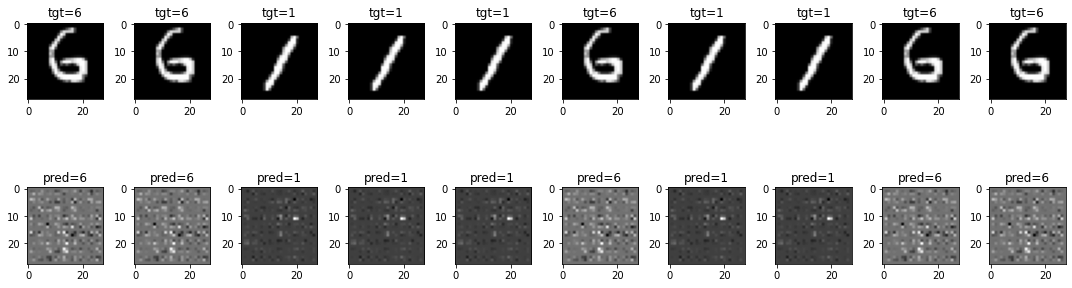

In [15]:
import numpy as np

state = torch.load(OUTPUT_PATH/'runs/test'/'state_small_inv_nn.pt')
inv_model.load_state_dict(state['model_state'])

plt.figure(figsize=(15, 5))
total_plts = 10
for i in range(total_plts):
    _ = np.random.randint(len(s))
    inp = model(s[_][0].to(device))
    label = torch.argmax(inp)
    o = inv_model(inp)
    img = o.squeeze().cpu().detach().numpy()
    ax_org = plt.subplot(2, 10, i+1)
    plt.imshow(s[_][0].squeeze().numpy(), cmap='gray')
    ax_pred = plt.subplot(2, 10, i+1+total_plts) 
    plt.imshow(img, cmap='gray')
    ax_pred.set_title(f'pred={label}')
    ax_org.set_title(f'tgt={s[_][1]}')
plt.tight_layout()
plt.show()